In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/home/mike/work/sdtools")

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.check_rates import *

# from remkit.load import load_remkit
# from code_comparison.code_comparison import *

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler("color", ["teal", "darkorange", "firebrick", "limegreen", "darkorchid", "deeppink", 
                                                   "#1E90FF", "forestgreen", "#4169e1", "darkgoldenrod", "#9370db", "crimson", "#2f4f4f" ])

sys.path.append(r"/home/mike/work/ReMKiT1D_H3/scripts")
from comp_utils import H3CompFromJSON,H3nTCompPlot,H3qGCompPlot,plotTermsThatEvolveVar

%load_ext autoreload
%autoreload 2

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

toload = [
    
    # Adding complexity
    # dict(name="old_base", id="sc16b-fix_sources_fix_lofidelity_base", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="old_add_qei", id="sc17a-sc16b_add_Qei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="old_add_neutrals", id="sc18a-Qei_add_neutrals", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # dict(name="base", id="rkc1-base_from_sc16b", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    dict(name="add_qei", id="rkc2-Qei_from_sc17a", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Commit of the selective-collisions merge. Has the bug.
    # dict(name="add_qei_test_selcollmerge", id="rkc2b-test-selcollmerge-3afdcc3", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Replace the entire collisions component with the one from remkit-comparison. Has the bug.
    # dict(name="add_qei_test_selcollmerge_oldcoll", id="rkc2c-test-selcollmerge-oldcollisions", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Replace the entire evolve_pressure component with the one from remkit-comparison. Doesn't have the bug.
    # The bug is in evolve_pressure.
    # dict(name="add_qei_test_selcollmerge_oldcoll_oldpress", id="rkc2d-test-selcollmerge-oldcoll_oldpress", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Now work backwards towards master. Replace kappa selection with the new routines. It has no bug.
    # The bug is in the kappa selection code. Really???
    # dict(name="steppress_update_kappasel", id="rkc2e-test-selcollmerge-oldcoll_steppress_update_kappasel", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Double check: go back to master and only change kappa selection. STILL BUG! so it's somewhere else...
    # dict(name="master-old_kappasel", id="rkc2f-test-master-oldkappasel", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Check again... how about we go from other direction and give master entire old evolve_pressure.
    # NO BUG! OK - so it's in evolve_pressure but not in the kappa selection. 
    # dict(name="master-old_pressure", id="rkc2g-test-master-oldpressure", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Now also replacing the nu selection with the old one. NO BUG!
    # The bug is in the nu selection for sure. 
    # dict(name="master-old_nusel", id="rkc2h-test-master-oldnusel", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    
    ###### Now let's compare the old add_qei to new add_qei on master after only one RHS. The profiles should be the same, but I bet K is different.
    # dict(name="old_add_qei", id="sc17a-sc16b_add_Qei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Verified to be OK.
    dict(name="old_add_qei_rerun", id="rkc2aa-OLD_QEI_RERUN", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="old_add_qei_onerhs", id="rkc2ab-NEW_QEI_ONERHS", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    dict(name="new_qei_fix", id="rkc2ac-NEW_QEI_FIX", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
]
#
for case in toload:
    print(f"Loading case {case['name']} from {case['id']}")
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])
    cs[case["name"]].ds.load()


Loading case add_qei from rkc2-Qei_from_sc17a
Loading case old_add_qei_rerun from rkc2aa-OLD_QEI_RERUN
Loading case new_qei_fix from rkc2ac-NEW_QEI_FIX


/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


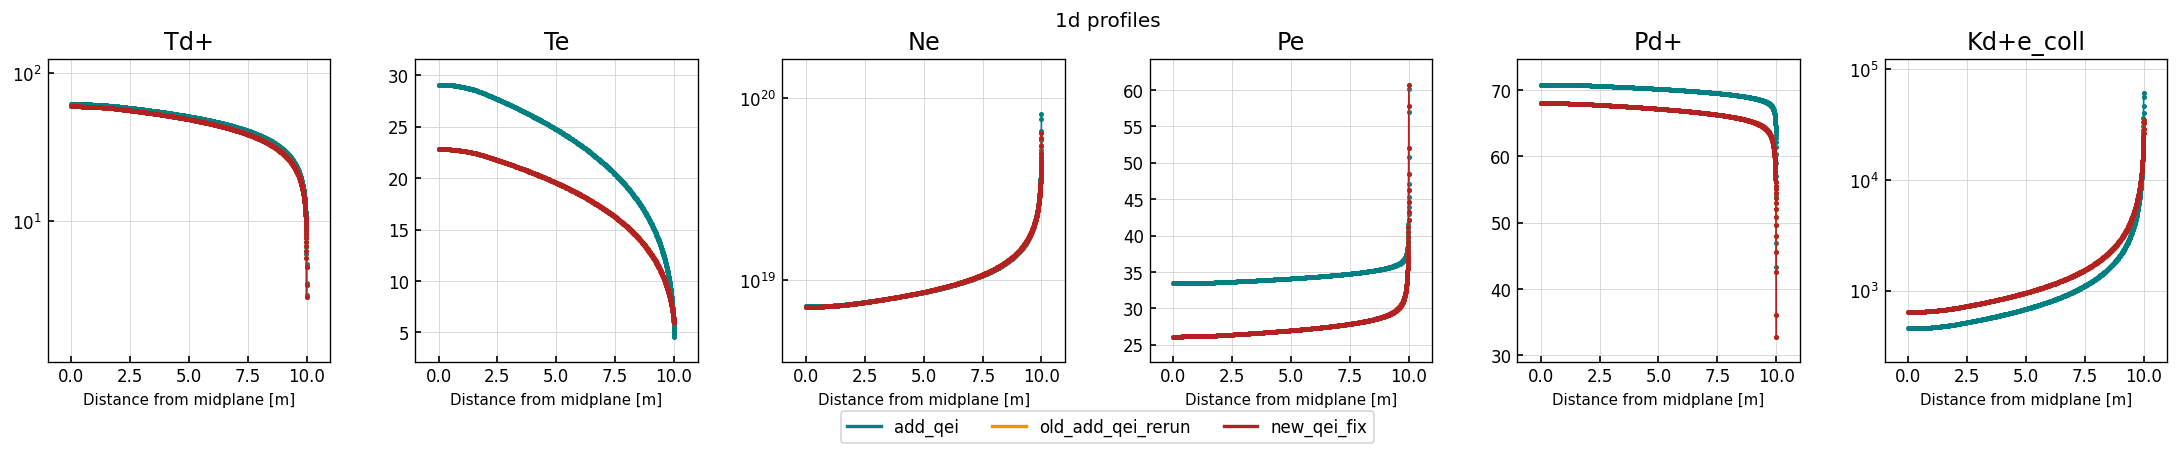

In [3]:
toplot = {}
for name in cs:
    toplot[name] = cs[name].ds.bout.final_time()


lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = True,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "Kd+e_coll"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

# NEW

Text(0.5, 1.0, 'Comparing e conduction collisionalities. Markers are Kee_coll, lines are Ke_cond')

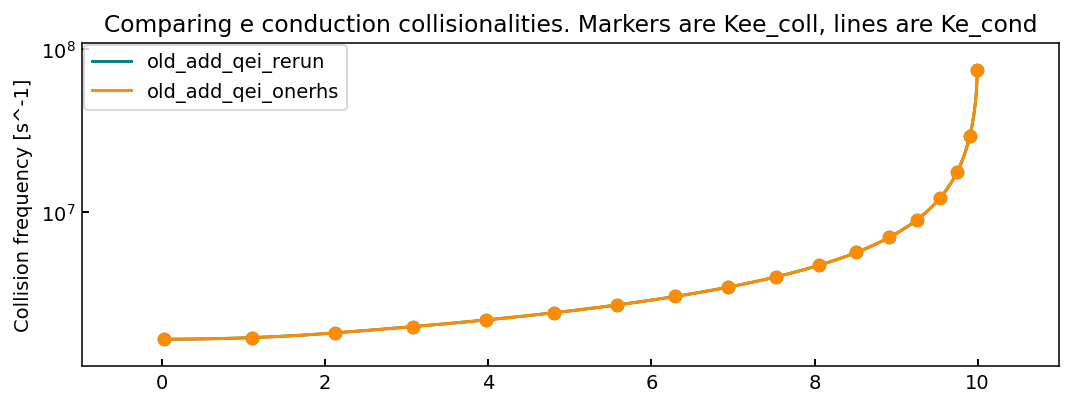

In [4]:
fig, ax = plt.subplots(figsize = (9,3))

for i, name in enumerate(cs.keys()):
    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath
    ax.plot(ds["pos"], ds["Ke_cond"], label = name, c = f"C{i}")
    ax.plot(ds["pos"][::30], ds["Kee_coll"][::30], "o", c = f"C{i}")
    ax.plot()
    
ax.set_ylabel("Collision frequency [s^-1]")
ax.set_yscale("log")
ax.legend()
ax.set_title("Comparing e conduction collisionalities. Markers are Kee_coll, lines are Ke_cond")

# OLD

In [4]:
for name, case in cs.items():
    if "t" in case.ds.bout.final_time().coords:
        print(f"{name} has time")
    else:
        print(f"{name} does not have time")

old_base has time
old_add_qei has time
base has time
add_qei does not have time


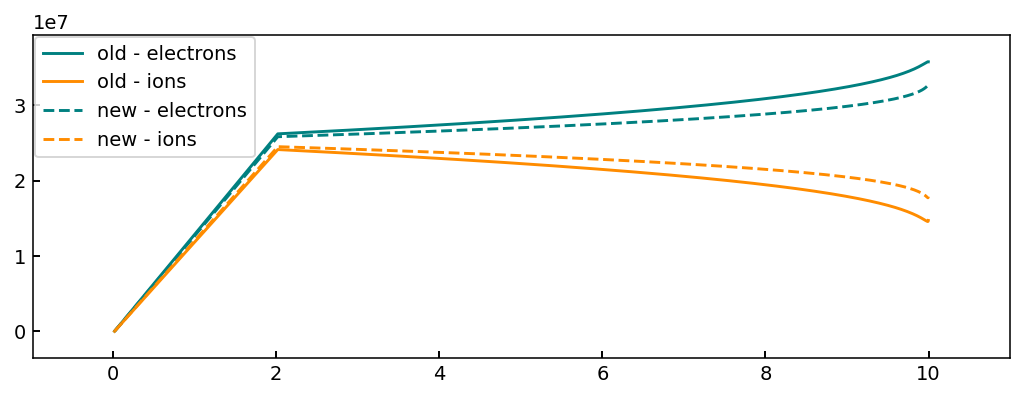

In [18]:
fig, ax = plt.subplots(figsize = (9,3))
old = cs["old_add_qei"].ds.isel(pos = slice(2,-3)).bout.final_time()  # Skip sheath
new = cs["add_qei"].ds.isel(pos = slice(2,-3)).bout.final_time()  # Skip sheath

ax.plot(old["pos"], old["efe_cond_ylow"], label = "old - electrons", c = "C0")
ax.plot(old["pos"], old["efd+_cond_ylow"], label = "old - ions", c = "C1")
ax.plot(new["pos"], new["efe_cond_ylow"], label = "new - electrons", c = "C0", ls = "--")
ax.plot(new["pos"], new["efd+_cond_ylow"], label = "new - ions", c = "C1", ls = "--")

ax.legend()

# >>>> How can electrons have a lower conductive heat flux if the temperature gradient is steeper?

# >>>> Try to start from base and do one RHS so that profiles are the same - may make it easier to isolate stuff.

# Full flux balance - base

516 516 513 FrozenMappingWarningOnValuesAccess({'pos': 516})


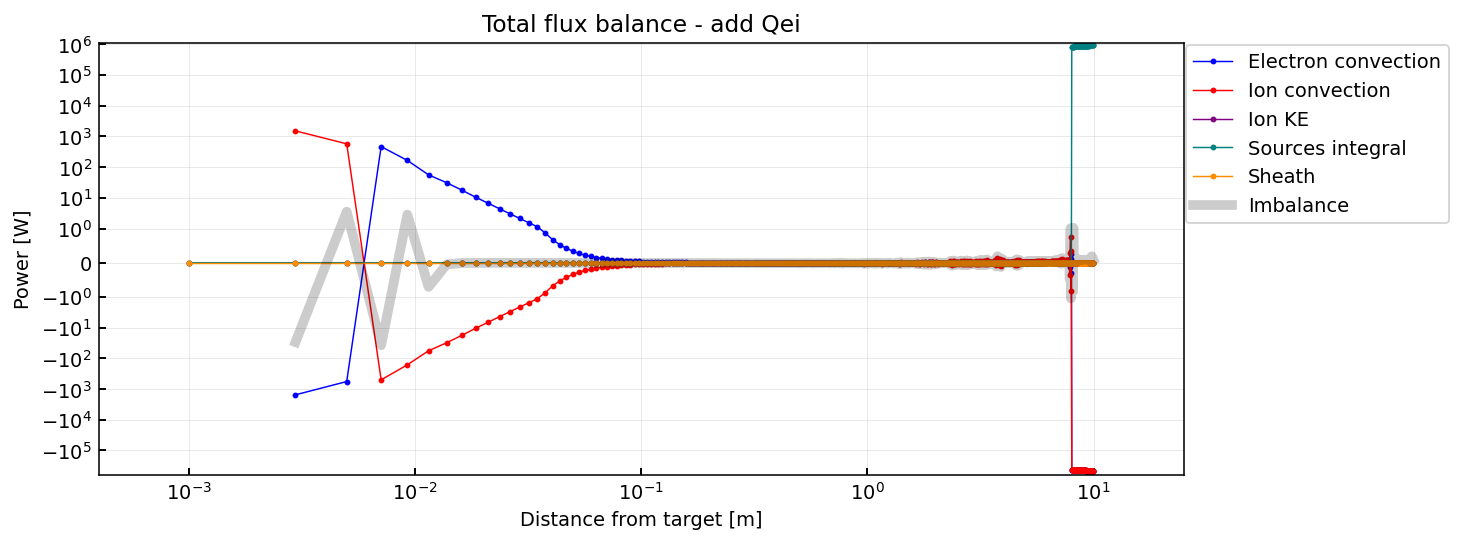

In [5]:
fbal = FluxBalance(cs["base"].ds, include_neutrals = False)
fbal.plot_total_balance()

# Flux balance - add Qei

516 516 513 FrozenMappingWarningOnValuesAccess({'pos': 516})


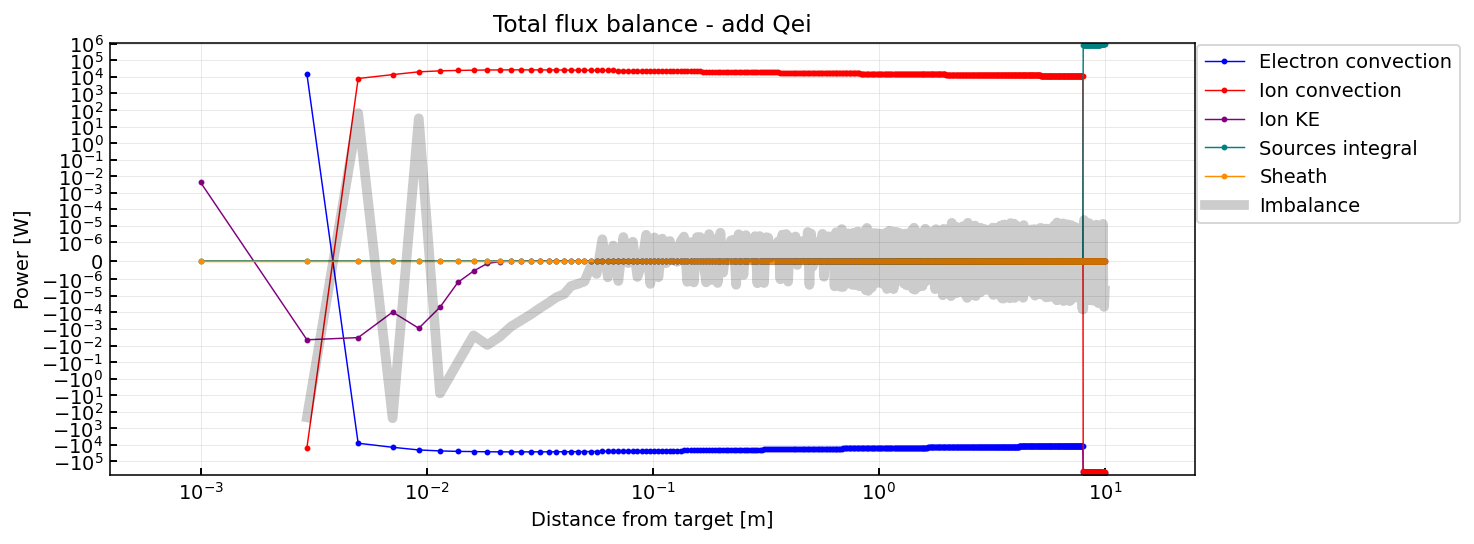

In [24]:
fbal = FluxBalance(cs["add_qei"].ds, include_neutrals = False)
fbal.plot_total_balance()

# Flux balance - add neutrals

516 516 513 FrozenMappingWarningOnValuesAccess({'pos': 516})


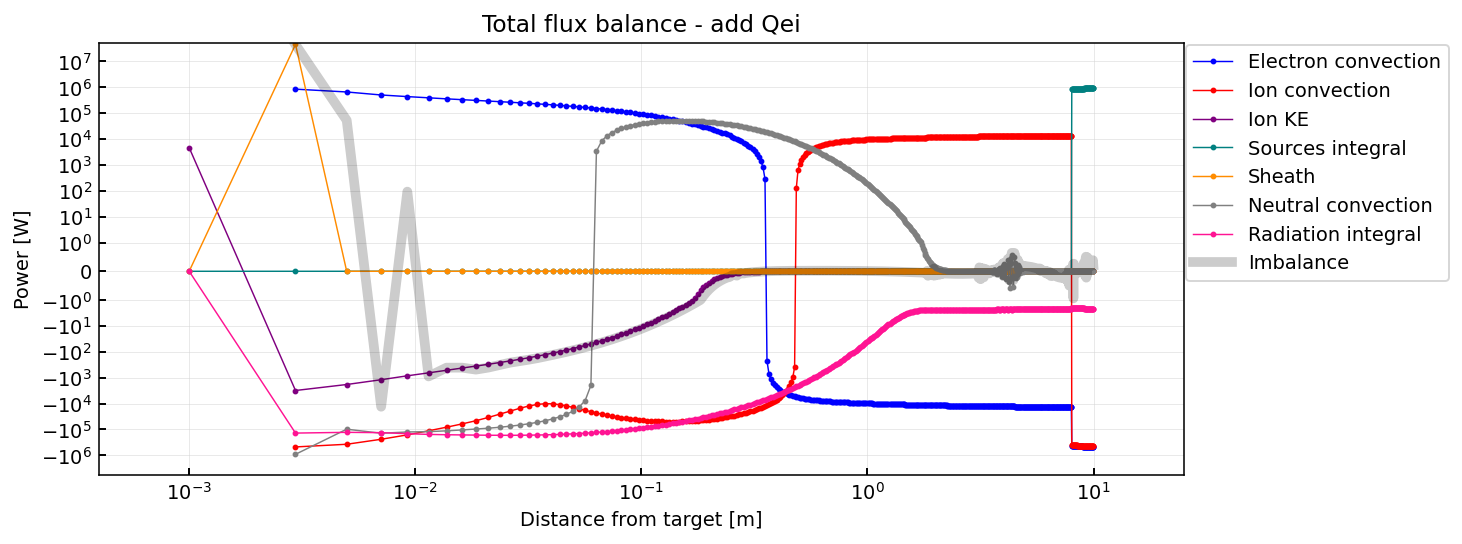

In [26]:
fbal = FluxBalance(cs["add_neutrals"].ds, include_neutrals = True)
fbal.plot_total_balance()

# Check against old cases

## Base

/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


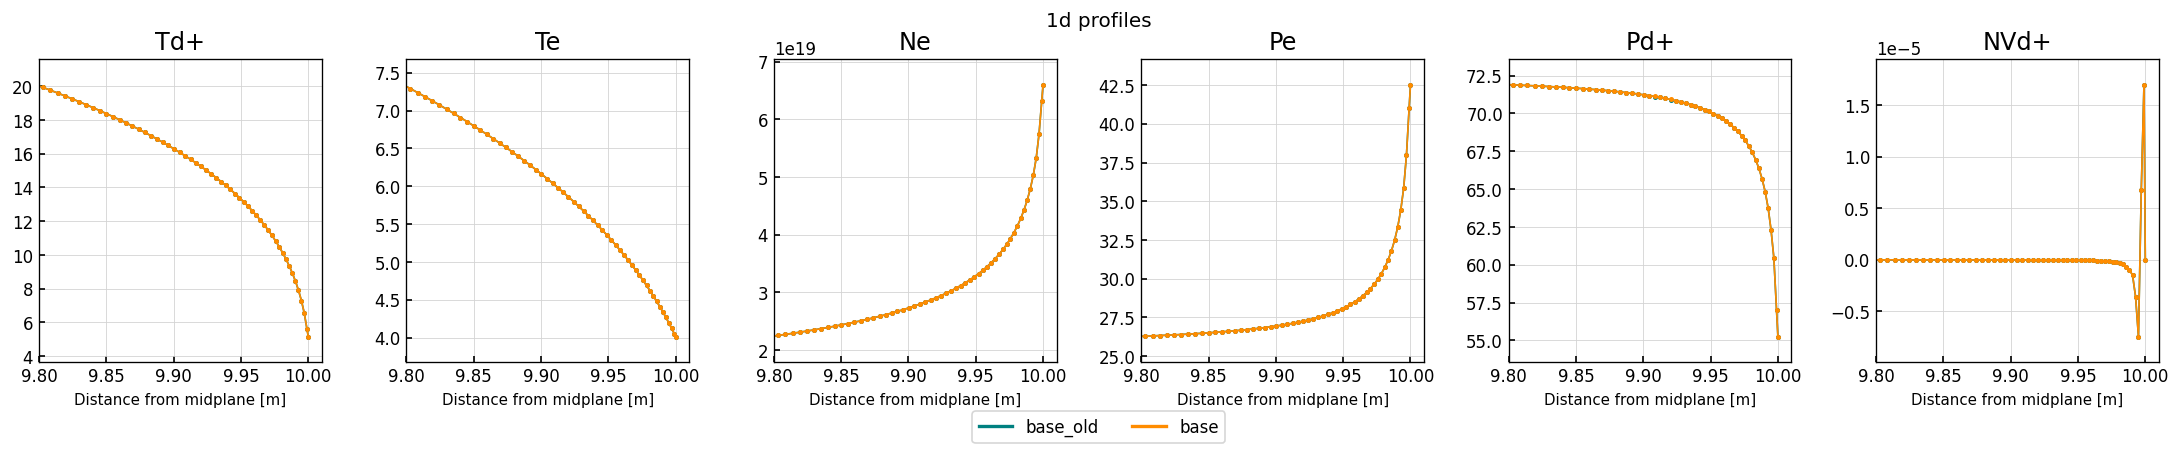

In [3]:
toplot = {
    "base_old" : cs["old_base"].ds.isel(t=-1),
    "base" : cs["base"].ds.isel(t=-1),
}

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

## Qei

/home/mike/work/sdtools/hermes3/plotting.py:760: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if "t" in  cases[name].dims.keys():


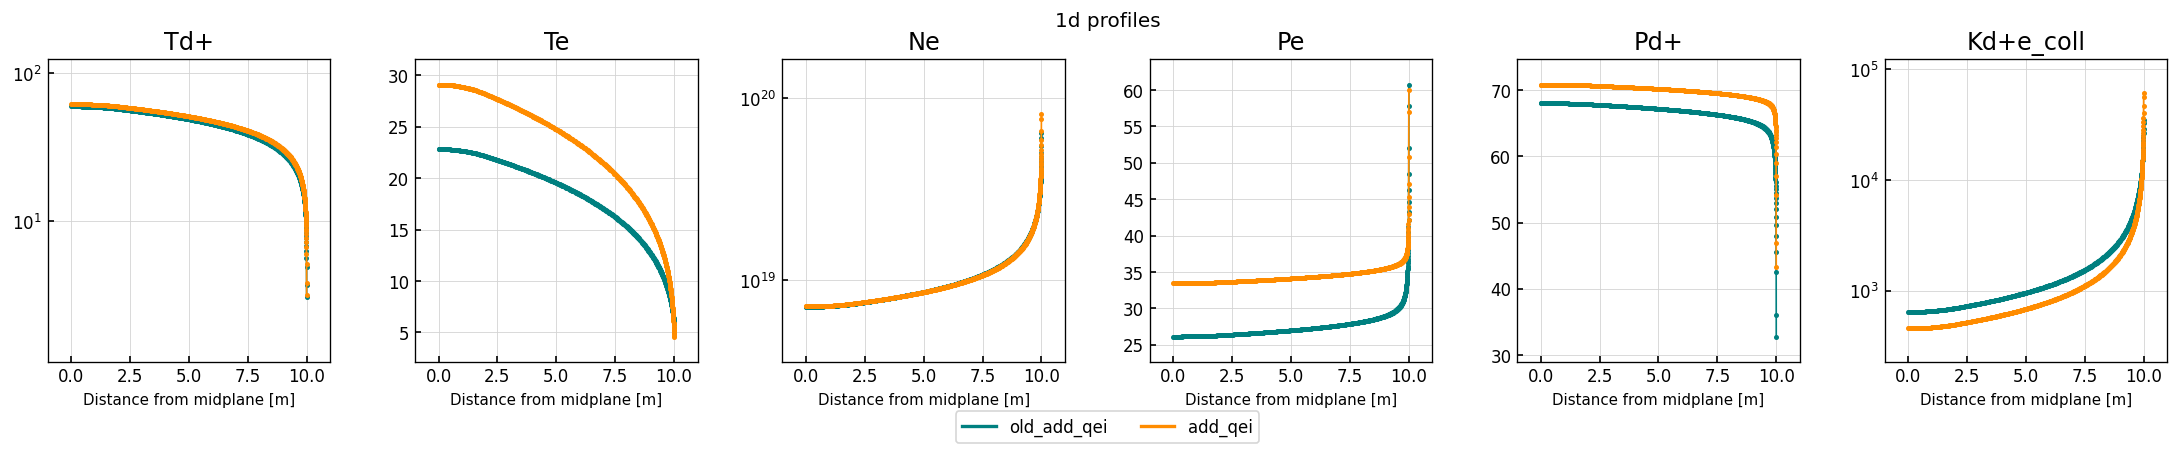

In [3]:
toplot = {
    # "base_old" : cs["old_base"].ds.isel(t=-1),
    # "base" : cs["base"].ds.isel(t=-1),
    "old_add_qei" : cs["old_add_qei"].ds.bout.final_time(),
    "add_qei" : cs["add_qei"].ds.bout.final_time(),
}


lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = True,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "Kd+e_coll"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

## Compare sources
Both cases have only Qei and Qin as electron sources.

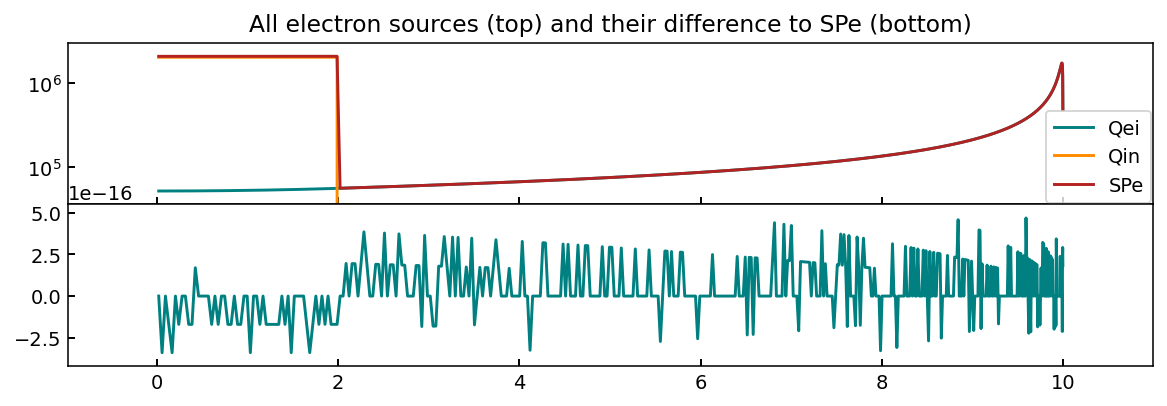

In [72]:
fig, axes = plt.subplots(2,1,figsize = (10,3), sharex=True)
fig.subplots_adjust(hspace=0)
name = "add_qei"

ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath 
ax = axes[0]
ax.plot(ds["pos"], ds["Eed+_coll"], label = "Qei")
ax.plot(ds["pos"], ds["Pd+_src"] * 3/2, label = "Qin")
ax.plot(ds["pos"], ds["SPe"]*3/2, label = "SPe")
ax.set_yscale("log")
ax.legend()
ax.set_title("All electron sources (top) and their difference to SPe (bottom)")

ax = axes[1]
total = ds["Eed+_coll"] + ds["Pd+_src"] * 3/2 
difference = (total - ds["SPe"]*3/2) / ds["SPe"]
ax.plot(ds["pos"], difference, label = "Difference")
# ax.plot(ds["pos"], ds["Eed+_coll_friction"], label = )


The sources are really the same. This means electron conductivity must be to blame.

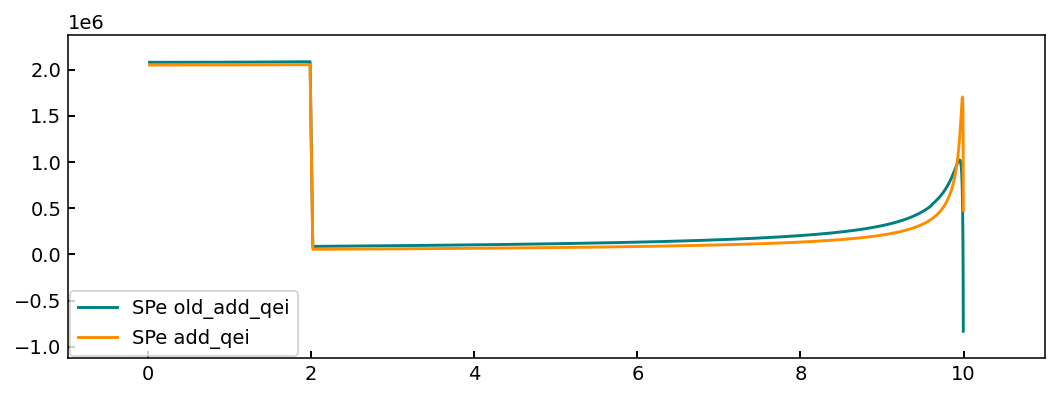

In [ ]:
fig, ax = plt.subplots(figsize = (9,3))

for name in ["old_add_qei", "add_qei"]:
    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath
    ax.plot(ds["pos"], ds["SPe"]*3/2, label = "SPe "+name)
ax.legend()

## Comparing electron conduction
Looks like both cases correctly have conduction K comprised of just Kee.

This makes no sense as add_qei is hotter so it should be more conductive.

Text(0.5, 1.0, 'Comparing e conduction collisionalities. Markers are Kee_coll, lines are Ke_cond')

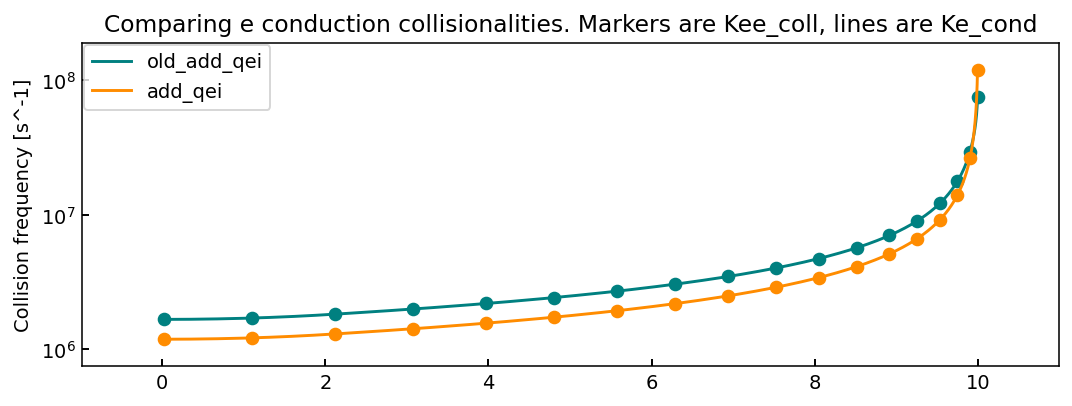

In [ ]:
fig, ax = plt.subplots(figsize = (9,3))

name = "add_qei"
for i, name in enumerate(["old_add_qei", "add_qei"]):
    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath
    ax.plot(ds["pos"], ds["Ke_cond"], label = name, c = f"C{i}")
    ax.plot(ds["pos"][::30], ds["Kee_coll"][::30], "o", c = f"C{i}")
    ax.plot()
    
ax.set_ylabel("Collision frequency [s^-1]")
ax.set_yscale("log")
ax.legend()
ax.set_title("Comparing e conduction collisionalities. Markers are Kee_coll, lines are Ke_cond")

I checked the kappa_coefficient inputs in BOUT.settings and they are correct.

Reconstructing kappa_par with the coefficient also gives the correct answer....

This means it's the collision time which is different.

Text(0.5, 1.0, 'Comparing kappa - markers = calculated')

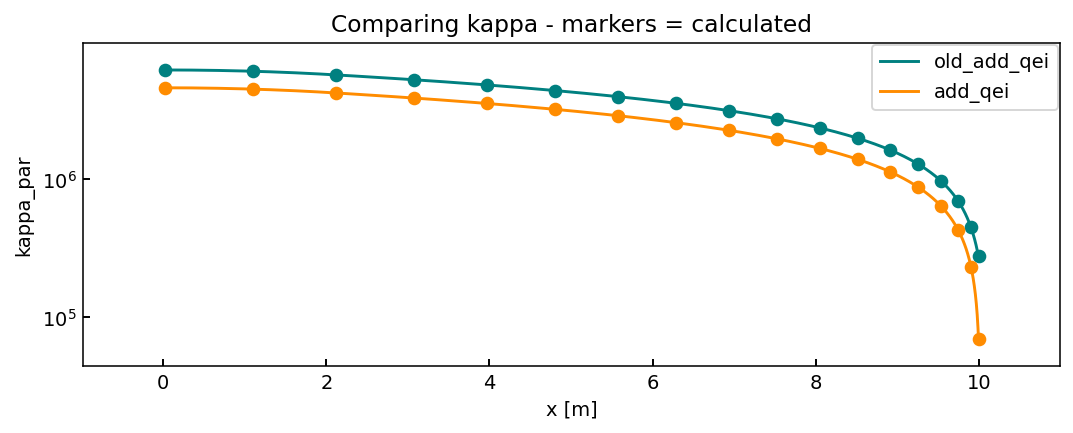

In [22]:
fig, ax = plt.subplots(figsize = (9,3))

name = "add_qei"
for i, name in enumerate(["old_add_qei", "add_qei"]):
    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath
    
    kappa_coefficient = 3.16 / np.sqrt(2)
    Pfloor = ds["Pe"]

    tau = ds["Ke_cond"]
    AA = 2
    
    ax.plot(ds["pos"], ds["kappa_par_e"], label = name, c = f"C{i}")
    ax.plot(ds["pos"][::30], ds["kappa_par_e"][::30], "o", c = f"C{i}")
    ax.plot()
    

ax.set_xlabel("x [m]")
ax.set_ylabel("kappa_par")
ax.set_yscale("log")
ax.legend()
ax.set_title("Comparing kappa - markers = calculated")

# Comparing electron conduction collisionality

In [ ]:

    const BoutReal Telim = floor(Te[i], 0.1);
    const BoutReal Nelim = floor(Ne[i], 1e10);
    const BoutReal logTe = log(Telim);
    // From NRL formulary 2019, page 34
    // Coefficient 30.4 from converting cm^-3 to m^-3
    // Note that this breaks when coulomb_log falls below 1
    const BoutReal coulomb_log = 30.4 - 0.5 * log(Nelim) + (5. / 4) * logTe
                            - sqrt(1e-5 + SQ(logTe - 2) / 16.);

    const BoutReal v1sq = 2 * Telim * SI::qe / SI::Me;

    // Collision frequency
    const BoutReal nu = SQ(SQ(SI::qe)) * floor(Ne[i], 0.0) * floor(coulomb_log, 1.0)
                    * 2 / (3 * pow(PI * 2 * v1sq, 1.5) * SQ(SI::e0 * SI::Me));

Text(0.5, 1.0, 'Comparing e conduction collisionalities. Markers are code, lines are reconstruction')

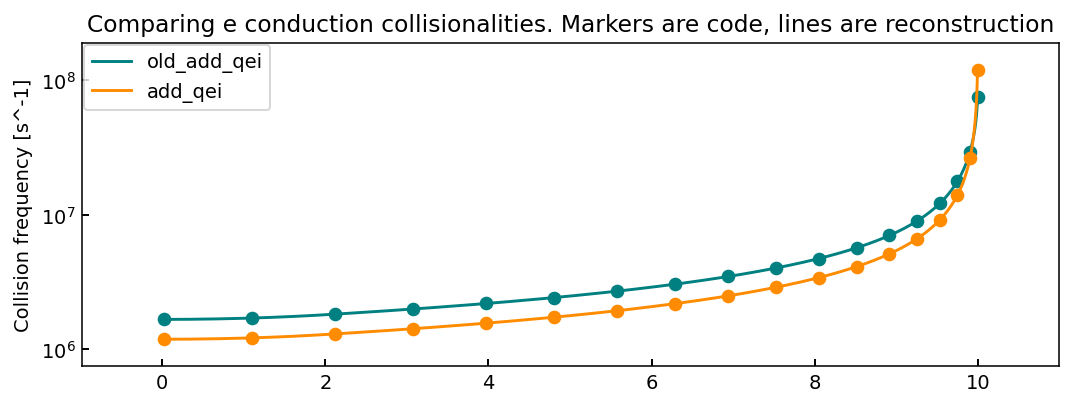

In [46]:
fig, ax = plt.subplots(figsize = (9,3))

name = "add_qei"
for i, name in enumerate(["old_add_qei", "add_qei"]):
    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-3))  # Skip sheath
    # ax.plot(ds["pos"], ds["Ke_cond"], label = name, c = f"C{i}")
    ax.plot(ds["pos"][::30], ds["Kee_coll"][::30], "o", c = f"C{i}")
    ax.plot(ds["pos"], get_Kee_coll(ds), label = name, c = f"C{i}")
    ax.plot()
    
ax.set_ylabel("Collision frequency [s^-1]")
ax.set_yscale("log")
ax.legend()
ax.set_title("Comparing e conduction collisionalities. Markers are code, lines are reconstruction")

In [ ]:
def softFloor(arr, min):
    
    for i, value in enumerate(arr):
        arr[i] = value + min * np.exp(-value / min)

    return arr

# def floor(value, min):
#     if value < min:
#         return min
#     else:
        # return value
        
        
# C++ CODE
    # const BoutReal Telim = floor(Te[i], 0.1);
    # const BoutReal Nelim = floor(Ne[i], 1e10);
    # const BoutReal logTe = log(Telim);
    # // From NRL formulary 2019, page 34
    # // Coefficient 30.4 from converting cm^-3 to m^-3
    # // Note that this breaks when coulomb_log falls below 1
    # const BoutReal coulomb_log = 30.4 - 0.5 * log(Nelim) + (5. / 4) * logTe
    #                         - sqrt(1e-5 + SQ(logTe - 2) / 16.);

    # const BoutReal v1sq = 2 * Telim * SI::qe / SI::Me;

    # // Collision frequency
    # const BoutReal nu = SQ(SQ(SI::qe)) * floor(Ne[i], 0.0) * floor(coulomb_log, 1.0)
    #                 * 2 / (3 * pow(PI * 2 * v1sq, 1.5) * SQ(SI::e0 * SI::Me));
    
# PYTHON CODE
Ai = 2
Mp = constants("mass_p")
Me = constants("mass_e")
qe = constants("q_e")
e0 = constants("e0")
    
Te = ds["Te"].values
Ne = ds["Ne"].values
Telim = np.clip(Te, 0.1, None)
Nelim = np.clip(Ne, 1e10, None)
logTe = np.log(Telim)

coulomb_log = 30.4 - 0.5 * np.log(Nelim) + (5 / 4) * logTe - np.sqrt(1e-5 + (logTe - 2)**2 / 16)

v1sq = 2 * Telim * qe / Me;

nu = (qe**2)**2 * np.clip(Ne, 0, None) * np.clip(coulomb_log, 1, None) * 2 / (3 * np.pi *2 * v1sq)**1.5 * (e0*Me)**2

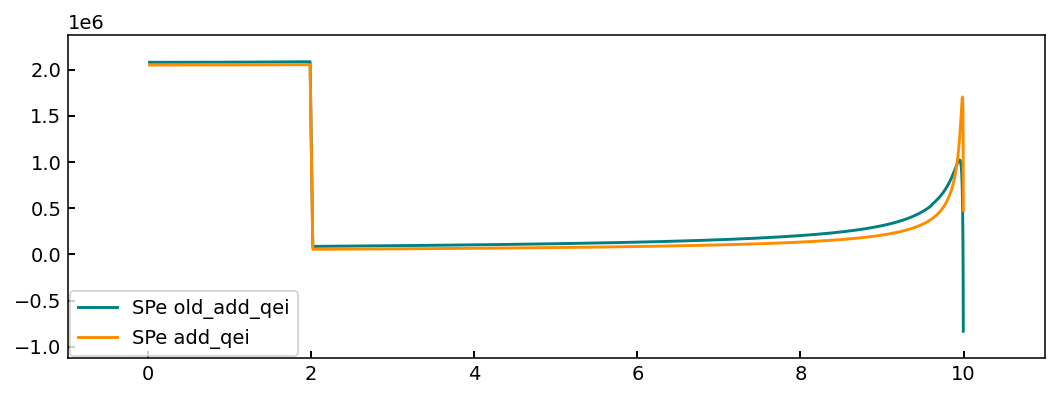

In [ ]:
ds = cs["add_qei"].ds.bout.final_time().isel(pos = slice(2,-2))  

Te = 

# Qei comparison

## Te-Ti

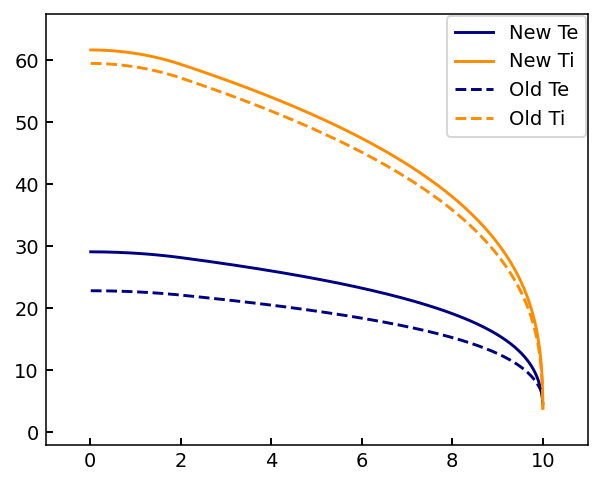

In [ ]:
fig, ax = plt.subplots()

base = cs["base"].ds.isel(t=-1, pos = slice(2,-2))
old_base = cs["old_base"].ds.isel(t=-1, pos = slice(2,-2))
qei = cs["add_qei"].ds.isel(pos = slice(2,-2))
old_qei = cs["old_add_qei"].ds.isel(t=-1, pos = slice(2,-2))

# ax.plot(base["pos"], base["Te"], c = "navy")
# ax.plot(base["pos"], base["Td+"], c = "darkorange")
# ax.plot(old_base["pos"], old_base["Te"],ls = "--", c = "navy")
# ax.plot(old_base["pos"], old_base["Td+"],ls = "--", c = "darkorange")

ax.plot(qei["pos"], qei["Te"], c = "navy", label = "New Te")
ax.plot(qei["pos"], qei["Td+"], c = "darkorange", label = "New Ti")
ax.plot(old_qei["pos"], old_qei["Te"],ls = "--", c = "navy", label = "Old Te")
ax.plot(old_qei["pos"], old_qei["Td+"],ls = "--", c = "darkorange", label = "Old Ti")
ax.legend()

## Fluxes

In [48]:
cs.keys()

dict_keys(['old_base', 'old_add_qei', 'base', 'add_qei'])

# Check Qei frequency
Using formula from current master shows a match for both cases.

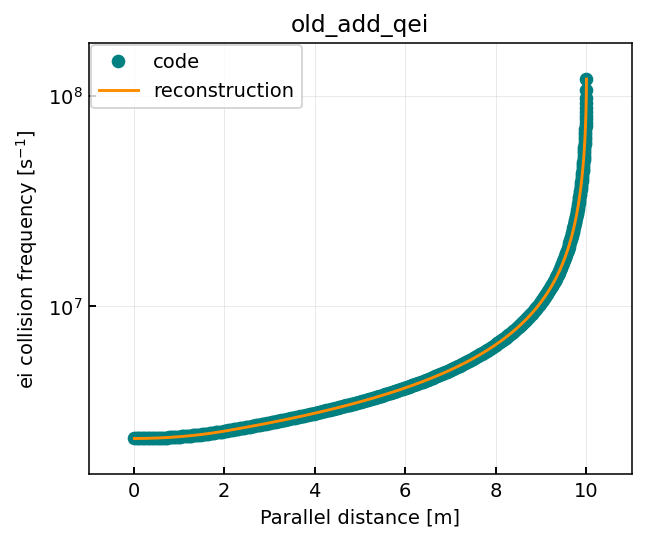

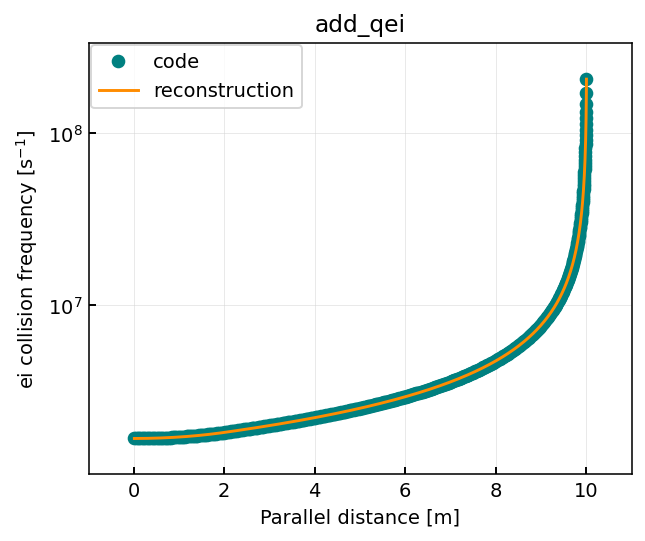

In [49]:
for name in ["old_add_qei", "add_qei"]:

    ds = cs[name].ds.bout.final_time().isel(pos = slice(2,-2))

    nu = get_Kei_coll(ds)
        
    fig, ax = plt.subplots()

    ax.plot(ds["pos"], ds["Ked+_coll"], "o", label = "code")
    ax.plot(ds["pos"], nu, label = "reconstruction")
    ax.set_yscale("log")
    ax.grid()
    ax.set_xlabel("Parallel distance [m]")
    ax.set_ylabel("ei collision frequency [s$^{-1}$]")
    ax.legend()
    ax.set_title(name)